In [1]:
!git clone https://github.com/ksideks/UCSD.git

fatal: docelowa ścieżka „UCSD” już istnieje i nie jest pustym katalogiem.


In [2]:
!pip install keras-layer-normalization

In [3]:
TestVideoFile = {}
TestVideoFile[1] = range(59,152)
TestVideoFile[2] = range(49,175)
TestVideoFile[3] = range(90,200)
TestVideoFile[4] = range(30,168)
TestVideoFile[5] = list(range(4,90)) + list(range(139,200))
TestVideoFile[6] = list(range(0,100)) + list(range(109,200))
TestVideoFile[7] = range(0,175)
TestVideoFile[8] = range(0,94)
TestVideoFile[9] = range(0,48)
TestVideoFile[10] = range(0,140)
TestVideoFile[11] = range(69,165)
TestVideoFile[12] = range(130,200)
TestVideoFile[13] = range(0,156)
TestVideoFile[14] = range(6,200)
TestVideoFile[15] = range(137,200)
TestVideoFile[16] = range(122,200)
TestVideoFile[17] = range(0,47)
TestVideoFile[18] = range(53,120)
TestVideoFile[19] = range(63,138)
TestVideoFile[20] = range(44,175)
TestVideoFile[21] = range(30,200)
TestVideoFile[22] = range(16,107)
TestVideoFile[23] = range(8,165)
TestVideoFile[24] = range(49,171)
TestVideoFile[25] = range(39,135)
TestVideoFile[26] = range(77,144)
TestVideoFile[27] = range(9,122)
TestVideoFile[28] = range(104,200)
TestVideoFile[29] = list(range(0,15)) + list(range(44,113))
TestVideoFile[30] = range(174,200)
TestVideoFile[31] = range(0,180)
TestVideoFile[32] = list(range(0,52)) + list(range(64,115))
TestVideoFile[33] = range(4,165)
TestVideoFile[34] = range(0,121)
TestVideoFile[35] = range(85,200)
TestVideoFile[36] = range(14,108)

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [5]:
class Config:
  DATASET_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  TEST_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
  SINGLE_TEST_VIDEO_FILE = 1
  SINGLE_TEST_PATH = "UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001"
  BATCH_SIZE = 64
  EPOCHS = 50
  MODEL_PATH = "UCSD_v5/model_v13.hdf5"
  THRESHOLD = 0.95

In [6]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 227 X 227
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 227, 227, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((227, 227))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [7]:
import keras
import tensorflow as tf 
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,227,227,1)
    
    seq = Sequential()
    
    #na podstawie oryginalu
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="valid"), batch_input_shape=(None, 10, 227, 227, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="valid")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(128, (5, 5), strides=2, padding="valid")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(1, (11, 11), strides=4, padding="valid")))
    #seq.add(LayerNormalization())
    #seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="valid")))
    
    print(seq.summary())
    
    seq.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3)) #, decay=1e-5, epsilon=1e-6))
    
    '''
    #AUTOENCODER --> spatial part
    
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="valid", activation=None,), batch_input_shape=(None, 10, 227, 227, 1))) #resizing to 227, 227
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="valid", activation=None,)))
    seq.add(LayerNormalization())

    
    # Convolutional Long-short term memory --> temporal part
    seq.add(ConvLSTM2D(64, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    # AUTODECODER --> spatial part  

    seq.add(TimeDistributed(Conv2DTranspose(128, (5, 5), strides=2, padding="valid", activation=None,)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(1, (11, 11), strides=4, padding="valid", activation=None,)))
    seq.add(LayerNormalization())
    
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    
    print(seq.summary())  # SUMMARY Should be visible /seq.summary(

    seq.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3)) #, decay=1e-5, epsilon=1e-6)) #no decay and no epsilon #changing learning rate --> 1e-3; lr=1e-4; 1e-3 etc.  
    
    '''
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

2021-11-15 15:52:47.414133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 15:52:47.414199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 227, 227, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((227, 227))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def evaluate(reload_model=False):
    model = get_model(reload_model)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 227, 227, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 227, 227, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=Config.BATCH_SIZE)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    return sr, sequences

2021-11-15 15:53:23.211775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-15 15:53:23.211901: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-15 15:53:23.211964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml): /proc/driver/nvidia/version does not exist
2021-11-15 15:53:23.212602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 55, 55, 128)  15616     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 55, 55, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 26, 26, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 26, 26, 64)   128       
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 26, 26, 64)    2

/home/user/notebook/jupyterenv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
22/22 [==============================] - 646s 27s/step - loss: 0.0909
Epoch 2/50
22/22 [==============================] - 582s 26s/step - loss: 0.0371
Epoch 3/50
22/22 [==============================] - 571s 26s/step - loss: 0.0327
Epoch 4/50
22/22 [==============================] - 579s 26s/step - loss: 0.0309
Epoch 5/50
22/22 [==============================] - 412s 19s/step - loss: 0.0293
Epoch 6/50
22/22 [==============================] - 425s 19s/step - loss: 0.0311
Epoch 7/50
22/22 [==============================] - 438s 20s/step - loss: 0.0302
Epoch 8/50
22/22 [==============================] - 443s 20s/step - loss: 0.0274
Epoch 9/50
22/22 [==============================] - 451s 20s/step - loss: 0.0257
Epoch 10/50
22/22 [==============================] - 444s 20s/step - loss: 0.0241
Epoch 11/50
22/22 [==============================] - 450s 20s/step - loss: 0.0223
Epoch 12/50
22/22 [==============================] - 441s 20s/step - loss: 0.0210
Epoch 13/50
22/22 [======

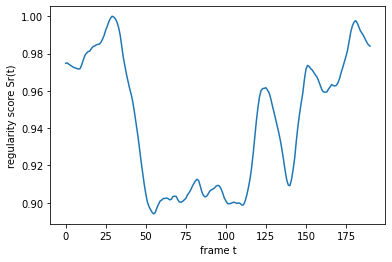

In [10]:
pr, before_reconstuction = evaluate(reload_model=True)

AUC:  0.9447004608294931
EER:  0.11827956989247312
EER THRESHOLD:  0.9487339155822294
Optimal threshold value is: 0.9577684153934224


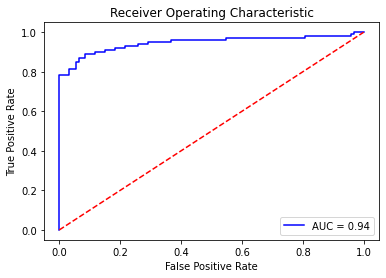

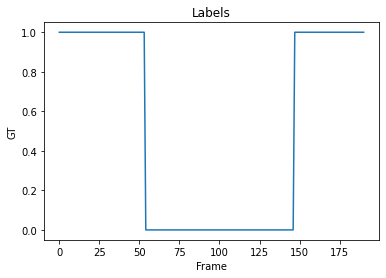

(0.9447004608294931, 0.11827956989247312)

In [11]:
from sklearn import metrics

def plotROC(pr):
  y_pred = pr
  y_test = [1 for element in range(0, 200)]

  for i in TestVideoFile[Config.SINGLE_TEST_VIDEO_FILE]:
    y_test[i] = 0

  #wariant 1 
  # y_test = y_test[9:]
  #wariant 2
  #y_test = y_test[:191]
  #wariant 3
  y_test = y_test[5:196]

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  fnr = 1 - tpr
  auc = metrics.roc_auc_score(y_test, y_pred)

  eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

  optimal = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal]


  #print("FPR: ", fpr)
  #print("TPR: ", tpr)
  #print("THRESHOLDS", thresholds)
  print("AUC: ", auc)
  print("EER: ", eer)
  print("EER THRESHOLD: ", eer_threshold)
  print("Optimal threshold value is:", optimal_threshold)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')  
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  plt.plot(y_test)
  plt.title('Labels')
  plt.ylabel('GT')
  plt.xlabel('Frame')
  plt.show()

  return auc, eer

plotROC(pr)


PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001
GT:  1
got model
(200, 227, 227, 1)
got data


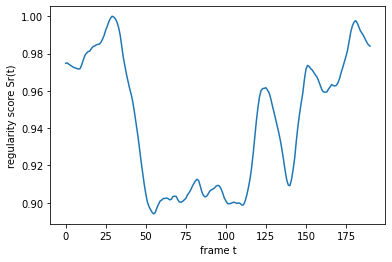

AUC:  0.9447004608294931
EER:  0.11827956989247312
EER THRESHOLD:  0.9487339155822294
Optimal threshold value is: 0.9577684153934224


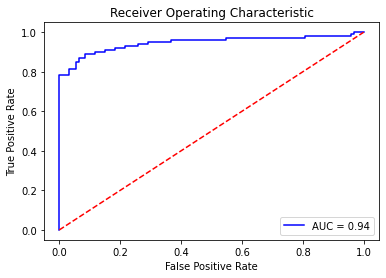

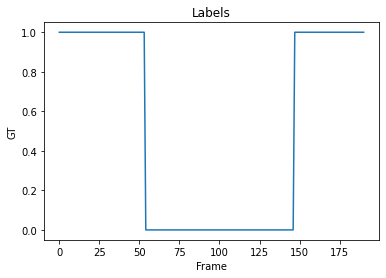

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test002
GT:  2
got model
(200, 227, 227, 1)
got data


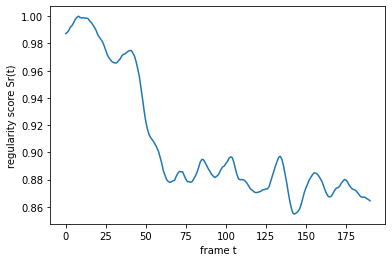

AUC:  0.7410256410256412
EER:  0.5634920634920635
EER THRESHOLD:  0.8803689489885681
Optimal threshold value is: 0.9656240321671415


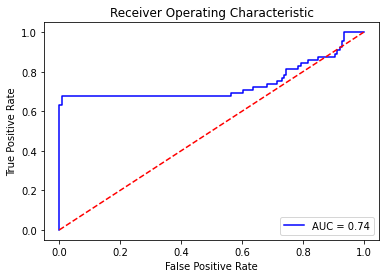

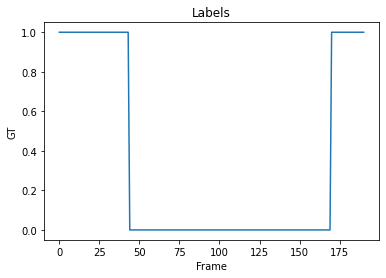

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test003
GT:  3
got model
(200, 227, 227, 1)
got data


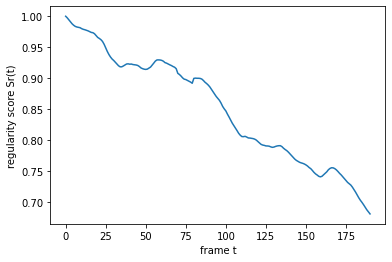

AUC:  0.9988901220865705
EER:  0.018867924528301886
EER THRESHOLD:  0.8935964418609077
Optimal threshold value is: 0.8916970837393091


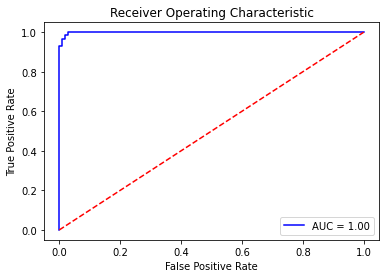

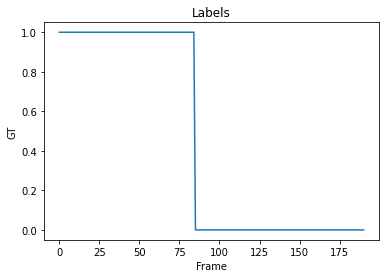

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004
GT:  4
got model
(200, 227, 227, 1)
got data


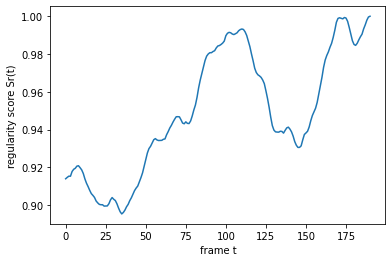

AUC:  0.5622094613070823
EER:  0.2028985507246377
EER THRESHOLD:  0.979230158018258
Optimal threshold value is: 0.984573471457163


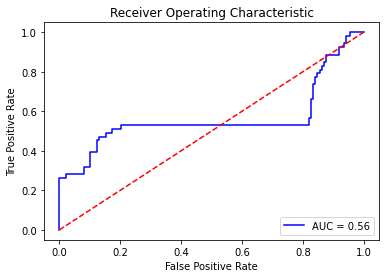

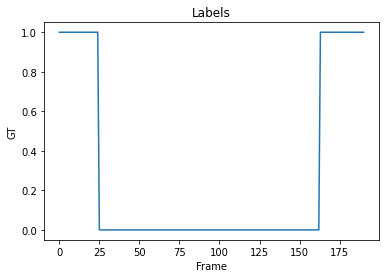

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test005
GT:  5
got model
(200, 227, 227, 1)
got data


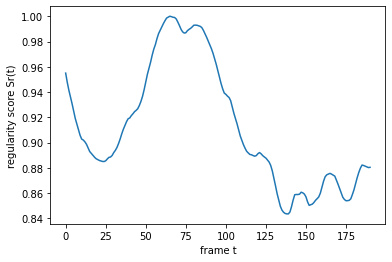

AUC:  0.5893935038804254
EER:  0.4647887323943662
EER THRESHOLD:  0.8986672691621774
Optimal threshold value is: 0.8886704349503364


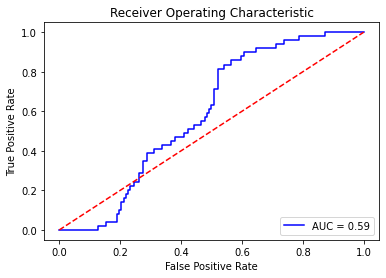

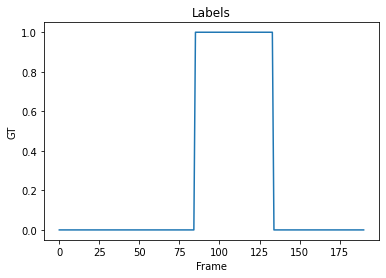

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test006
GT:  6
got model
(200, 227, 227, 1)
got data


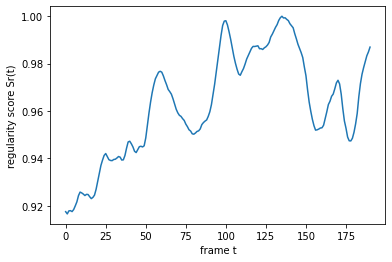

AUC:  0.9120879120879122
EER:  0.14285714285714285
EER THRESHOLD:  0.9867096816132159
Optimal threshold value is: 0.9818122669304623


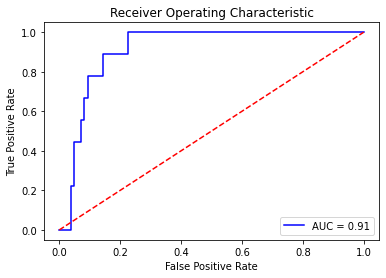

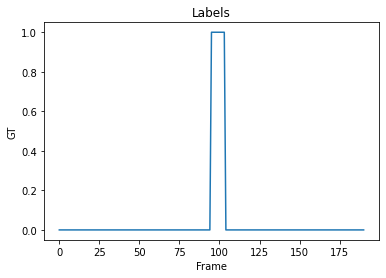

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test007
GT:  7
got model
(200, 227, 227, 1)
got data


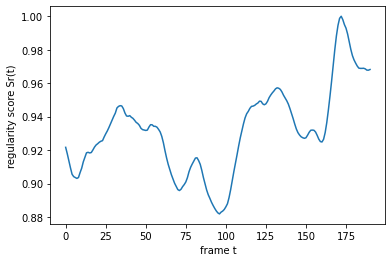

AUC:  0.9901960784313725
EER:  0.01764705882352941
EER THRESHOLD:  0.9677623544444215
Optimal threshold value is: 0.9677623544444215


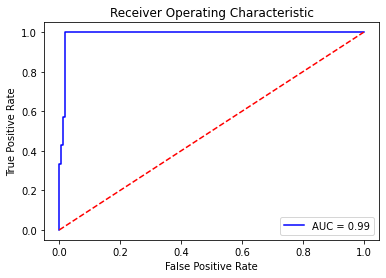

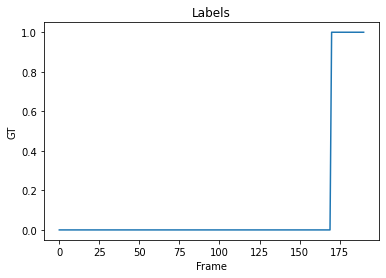

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test008
GT:  8
got model
(200, 227, 227, 1)
got data


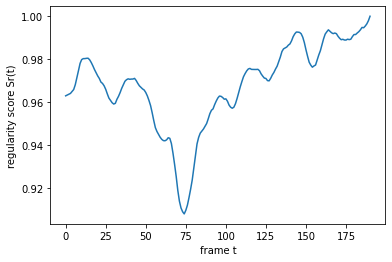

AUC:  0.8490857016964088
EER:  0.24719101123595505
EER THRESHOLD:  0.9701090897083365
Optimal threshold value is: 0.9711404548331746


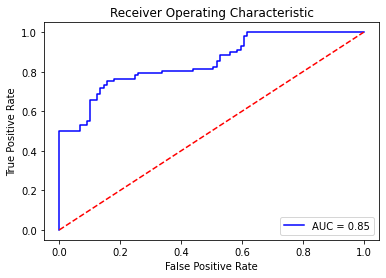

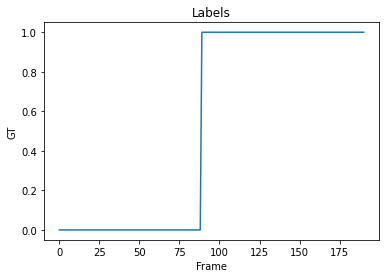

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test009
GT:  9
got model
(200, 227, 227, 1)
got data


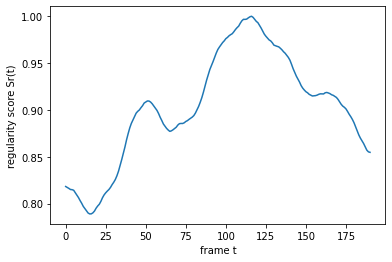

AUC:  0.9869578881206789
EER:  0.06976744186046512
EER THRESHOLD:  0.8771135671022845
Optimal threshold value is: 0.8771135671022845


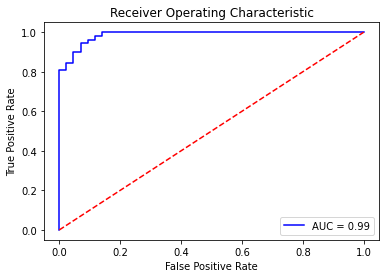

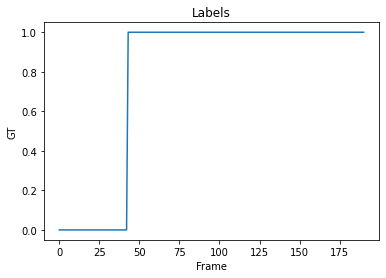

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test010
GT:  10
got model
(200, 227, 227, 1)
got data


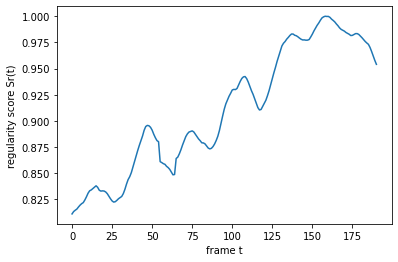

AUC:  0.9947089947089948
EER:  0.037037037037037035
EER THRESHOLD:  0.9621295643278767
Optimal threshold value is: 0.9540600661828567


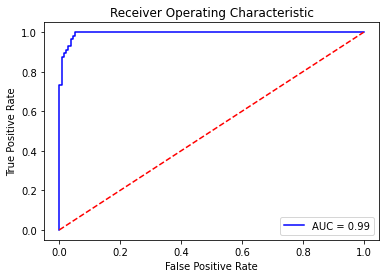

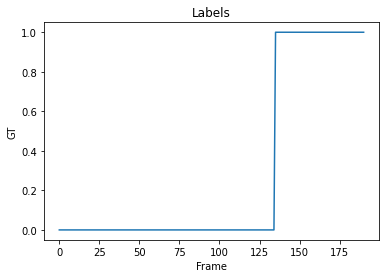

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test011
GT:  11
got model
(200, 227, 227, 1)
got data


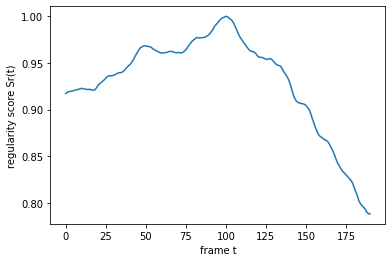

AUC:  0.21710526315789475
EER:  0.7395833333333334
EER THRESHOLD:  0.9467297196767505
Optimal threshold value is: 2.0


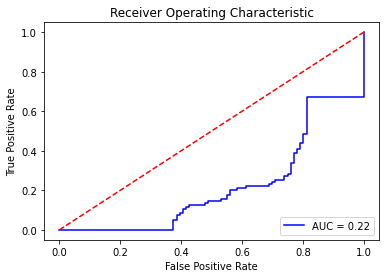

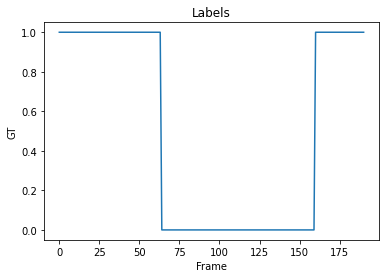

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test012
GT:  12
got model
(200, 227, 227, 1)
got data


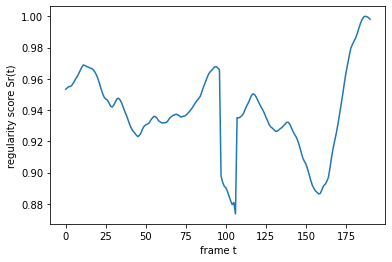

AUC:  0.6458181818181818
EER:  0.30303030303030304
EER THRESHOLD:  0.9354626331964899
Optimal threshold value is: 0.931549023840585


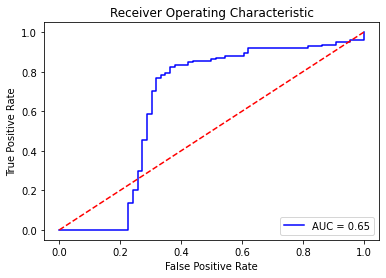

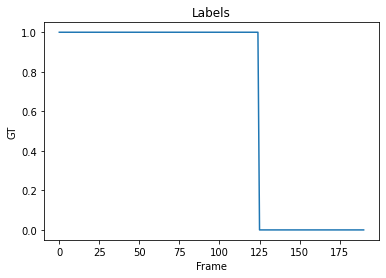

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test013
GT:  13
got model
(200, 227, 227, 1)
got data


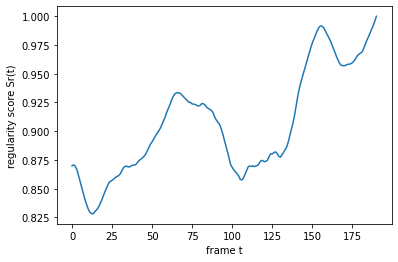

AUC:  0.9874172185430464
EER:  0.033112582781456956
EER THRESHOLD:  0.9569460525771948
Optimal threshold value is: 0.9569460525771948


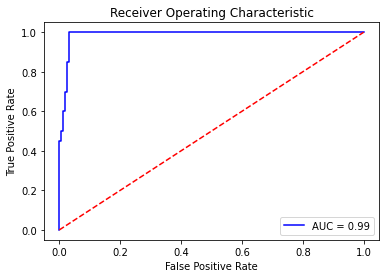

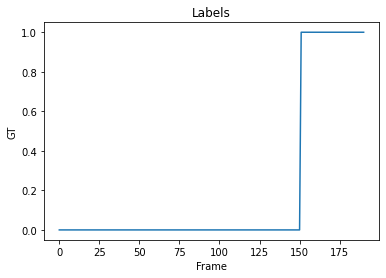

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014
GT:  14
got model
(200, 227, 227, 1)
got data


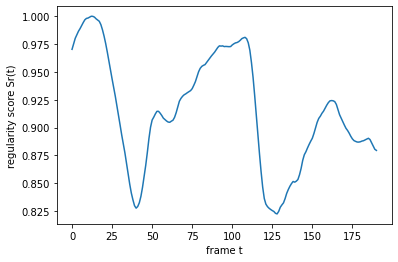

AUC:  0.7842105263157895
EER:  0.21578947368421053
EER THRESHOLD:  0.970292382275171
Optimal threshold value is: 0.970292382275171


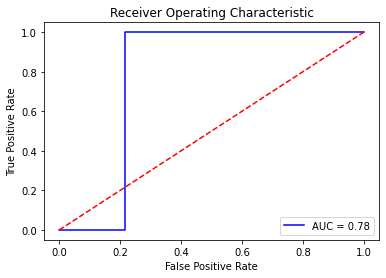

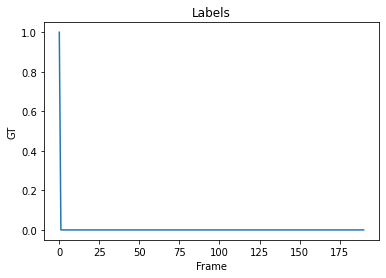

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test015
GT:  15
got model
(200, 227, 227, 1)
got data


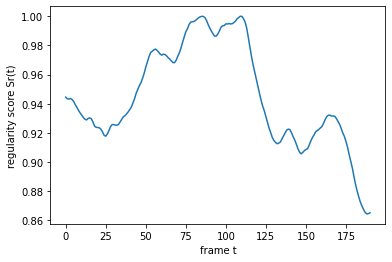

AUC:  0.9422187981510015
EER:  0.15254237288135594
EER THRESHOLD:  0.9269904900804328
Optimal threshold value is: 0.9321969006235146


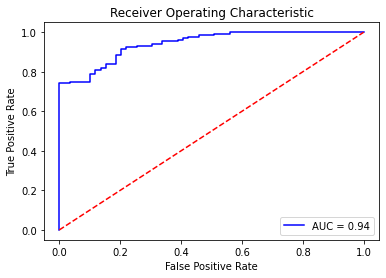

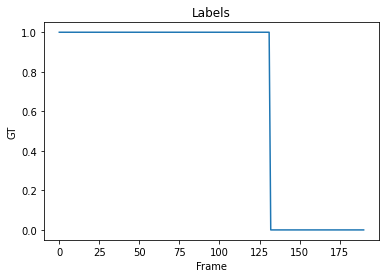

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test016
GT:  16
got model
(200, 227, 227, 1)
got data


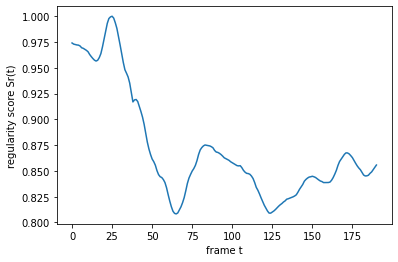

AUC:  0.8110418110418111
EER:  0.25675675675675674
EER THRESHOLD:  0.8498853814930957
Optimal threshold value is: 0.8679573031889984


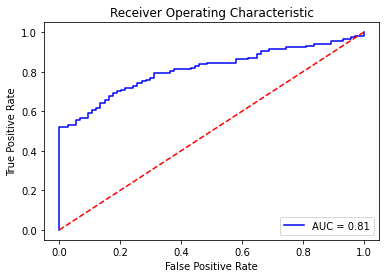

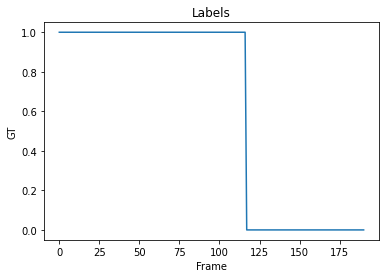

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test018
GT:  18
got model
(200, 227, 227, 1)
got data


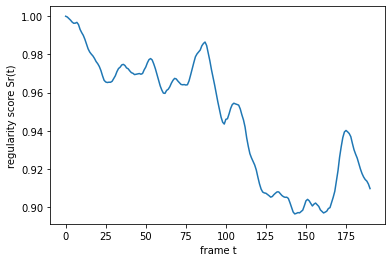

AUC:  0.30777563793933554
EER:  0.4626865671641791
EER THRESHOLD:  0.965314775780934
Optimal threshold value is: 0.9879350392058599


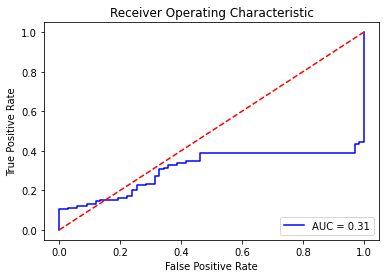

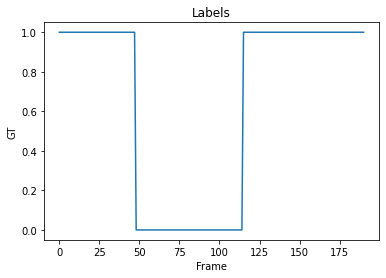

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019
GT:  19
got model
(200, 227, 227, 1)
got data


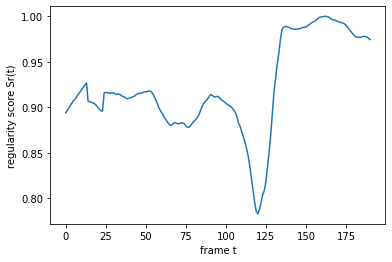

AUC:  0.9409195402298851
EER:  0.14666666666666667
EER THRESHOLD:  0.90910837923715
Optimal threshold value is: 0.90910837923715


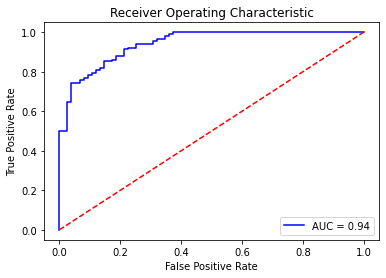

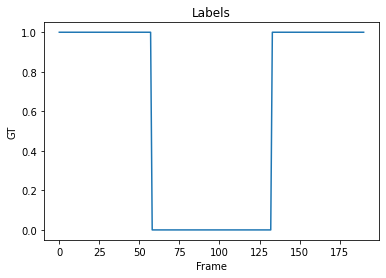

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test020
GT:  20
got model
(200, 227, 227, 1)
got data


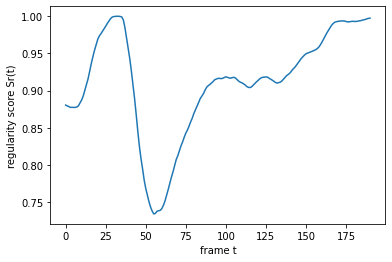

AUC:  0.8113231552162851
EER:  0.24427480916030533
EER THRESHOLD:  0.9261536876141879
Optimal threshold value is: 0.9615236731991037


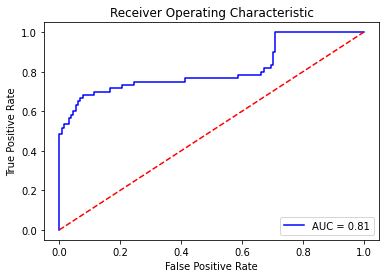

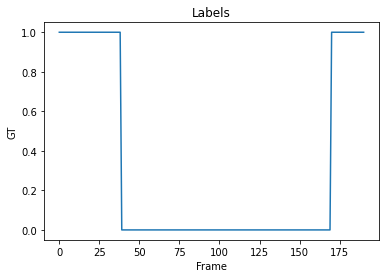

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test021
GT:  21
got model
(200, 227, 227, 1)
got data


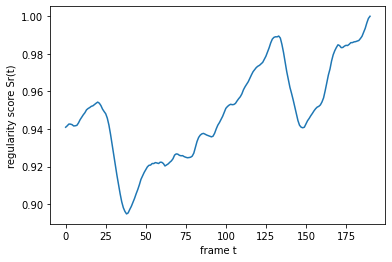

AUC:  0.5
EER:  0.4879518072289157
EER THRESHOLD:  0.9486329251051931
Optimal threshold value is: 0.9409189672354508


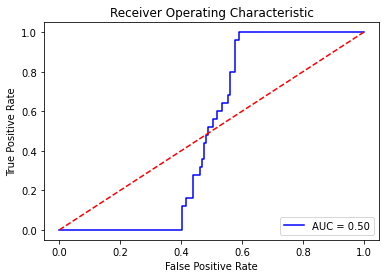

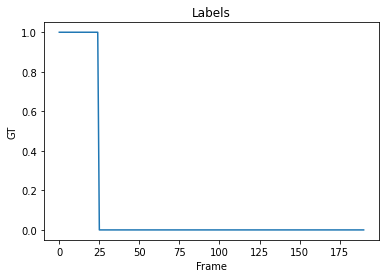

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test022
GT:  22
got model
(200, 227, 227, 1)
got data


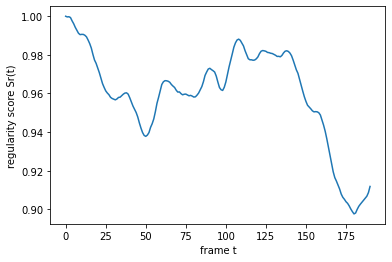

AUC:  0.5567032967032967
EER:  0.4835164835164835
EER THRESHOLD:  0.9613682952693424
Optimal threshold value is: 0.9737662484248654


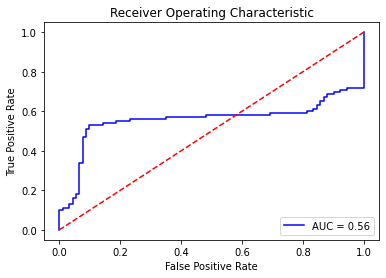

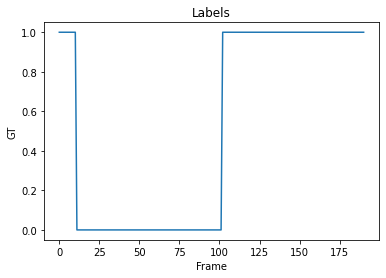

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test023
GT:  23
got model
(200, 227, 227, 1)
got data


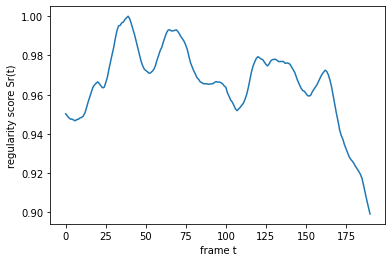

AUC:  0.1075309104533533
EER:  0.8407643312101911
EER THRESHOLD:  0.9595576125865939
Optimal threshold value is: 2.0


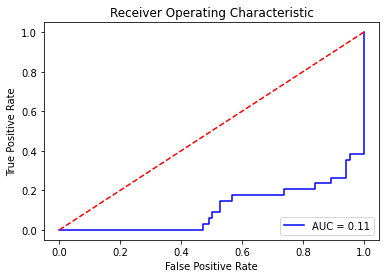

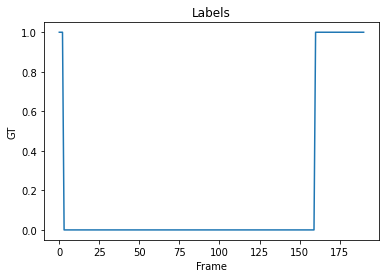

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024
GT:  24
got model
(200, 227, 227, 1)
got data


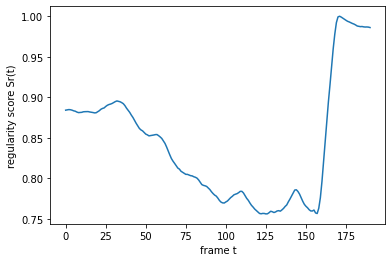

AUC:  0.9900213827512473
EER:  0.01639344262295082
EER THRESHOLD:  0.8715299632543535
Optimal threshold value is: 0.8715299632543535


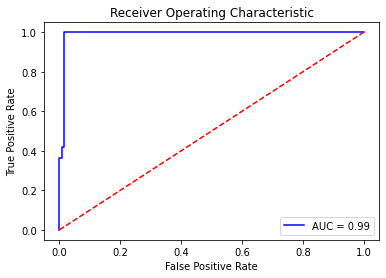

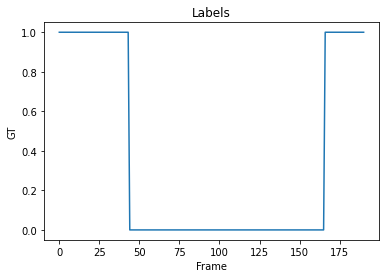

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test025
GT:  25
got model
(200, 227, 227, 1)
got data


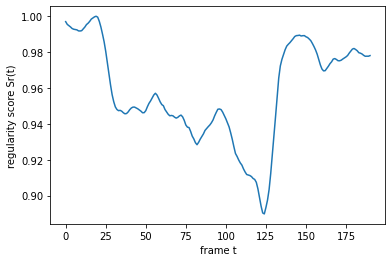

AUC:  0.981359649122807
EER:  0.0625
EER THRESHOLD:  0.9527626417121804
Optimal threshold value is: 0.9562683450060098


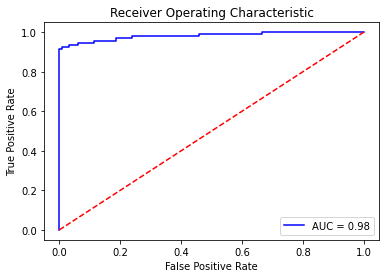

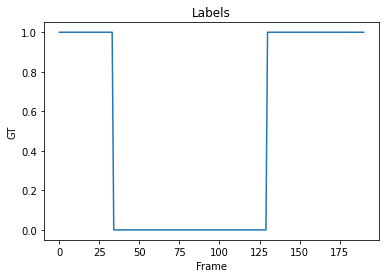

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test026
GT:  26
got model
(200, 227, 227, 1)
got data


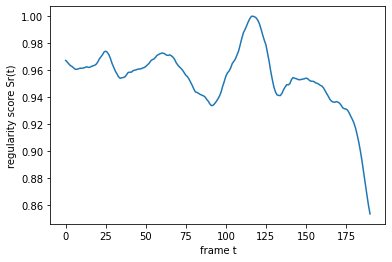

AUC:  0.466779008184882
EER:  0.4626865671641791
EER THRESHOLD:  0.9565774823936004
Optimal threshold value is: 0.9496621107311719


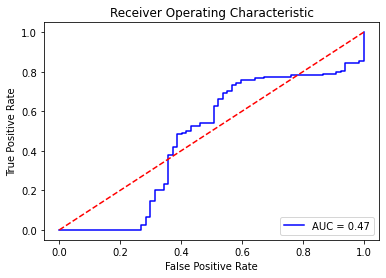

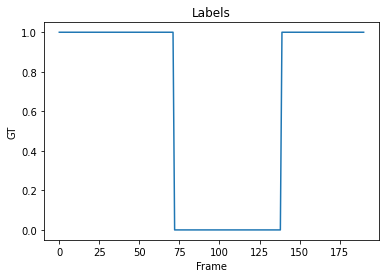

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test027
GT:  27
got model
(200, 227, 227, 1)
got data


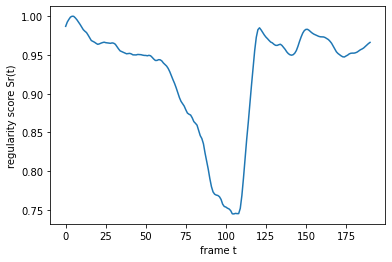

AUC:  0.7964601769911505
EER:  0.2743362831858407
EER THRESHOLD:  0.9552173508829076
Optimal threshold value is: 0.9502555441832329


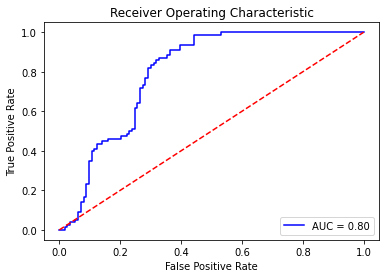

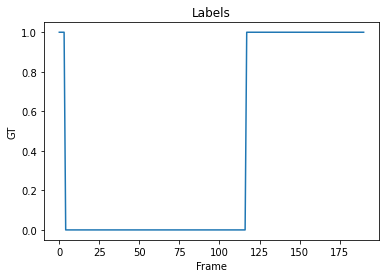

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test028
GT:  28
got model
(200, 227, 227, 1)
got data


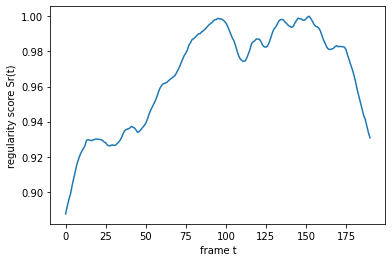

AUC:  0.19356609574000877
EER:  0.7608695652173914
EER THRESHOLD:  0.9789669607988513
Optimal threshold value is: 2.0


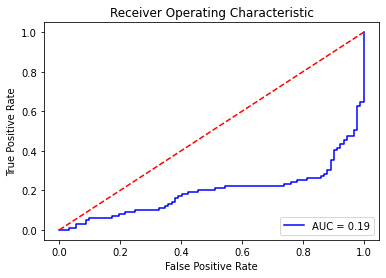

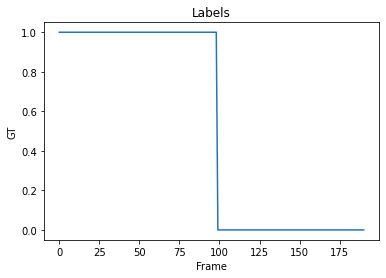

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test029
GT:  29
got model
(200, 227, 227, 1)
got data


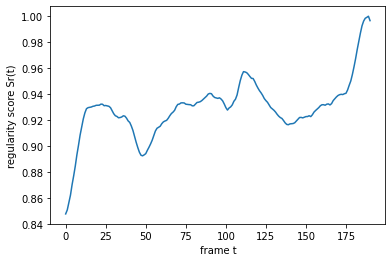

AUC:  0.6836573236889693
EER:  0.43037974683544306
EER THRESHOLD:  0.9305302783896412
Optimal threshold value is: 0.9163252357496933


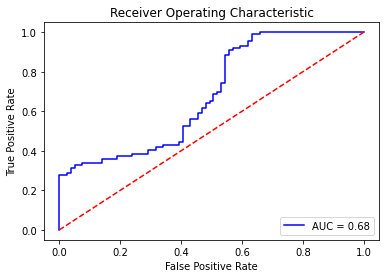

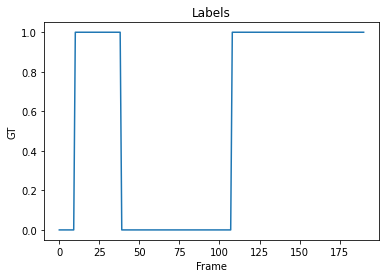

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test030
GT:  30
got model
(200, 227, 227, 1)
got data


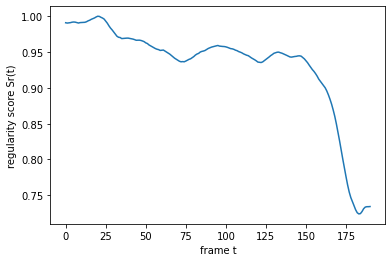

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.860186136077858
Optimal threshold value is: 0.860186136077858


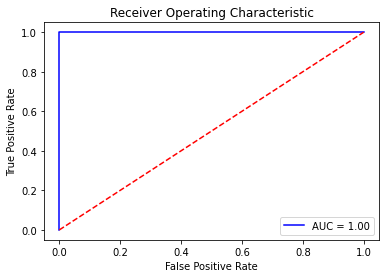

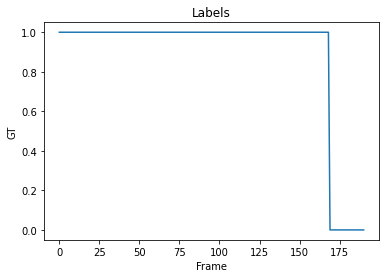

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test031
GT:  31
got model
(200, 227, 227, 1)
got data


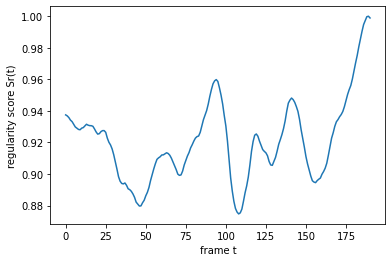

AUC:  0.9903571428571429
EER:  0.06285714285714286
EER THRESHOLD:  0.9468280332702707
Optimal threshold value is: 0.9465321511161141


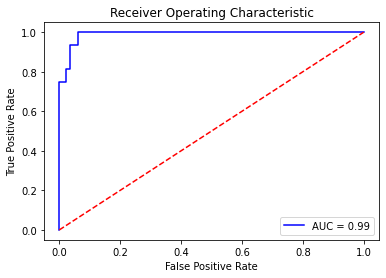

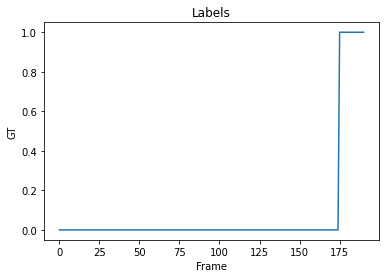

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032
GT:  32
got model
(200, 227, 227, 1)
got data


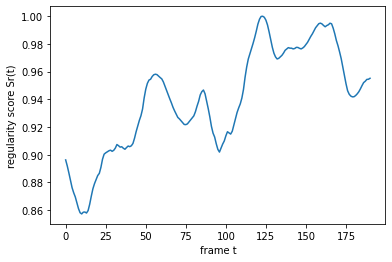

AUC:  0.9817862628922537
EER:  0.08163265306122448
EER THRESHOLD:  0.943695765873463
Optimal threshold value is: 0.9409521911925375


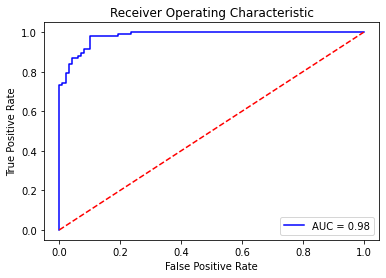

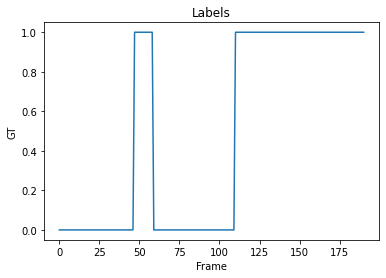

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test033
GT:  33
got model
(200, 227, 227, 1)
got data


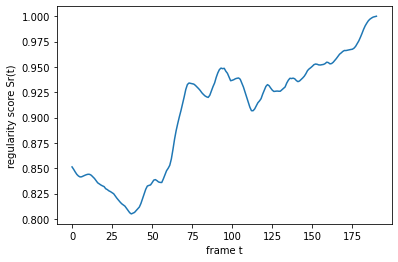

AUC:  0.998991935483871
EER:  0.0125
EER THRESHOLD:  0.9529876491912689
Optimal threshold value is: 0.9529876491912689


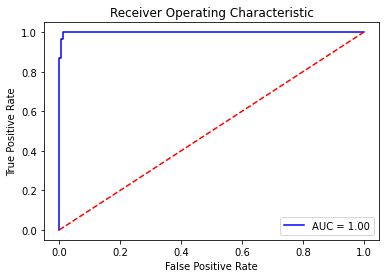

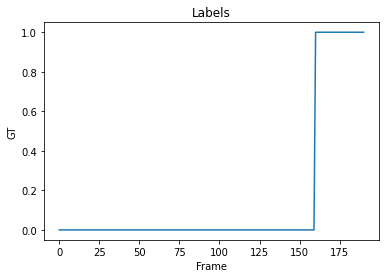

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test034
GT:  34
got model
(200, 227, 227, 1)
got data


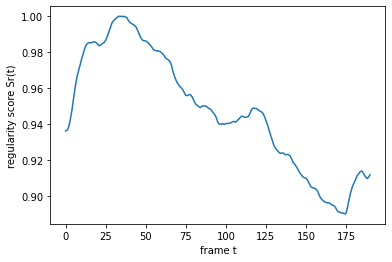

AUC:  0.03206896551724138
EER:  0.8620689655172413
EER THRESHOLD:  0.9419942898722046
Optimal threshold value is: 2.0


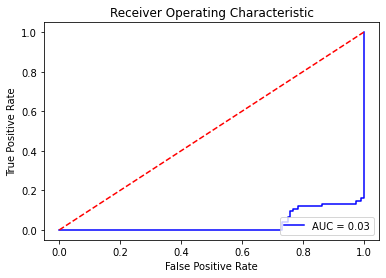

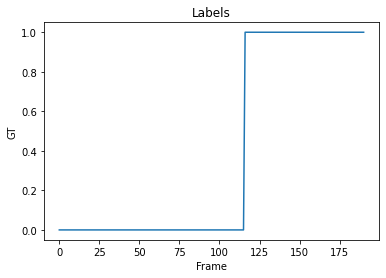

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test035
GT:  35
got model
(200, 227, 227, 1)
got data


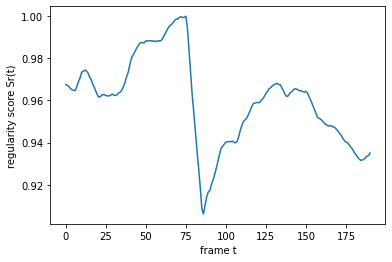

AUC:  0.942454954954955
EER:  0.1891891891891892
EER THRESHOLD:  0.9639305674633077
Optimal threshold value is: 0.9621440125356285


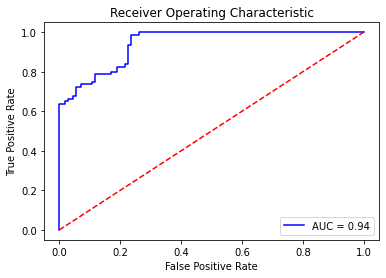

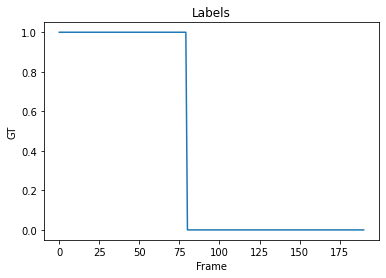

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036
GT:  36
got model
(200, 227, 227, 1)
got data


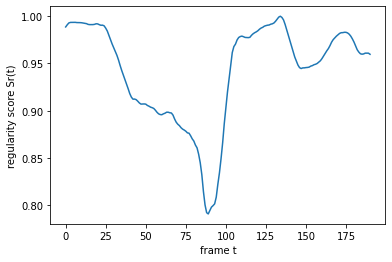

AUC:  0.8149813555604298
EER:  0.24468085106382978
EER THRESHOLD:  0.9597344954531337
Optimal threshold value is: 0.9446306823574644


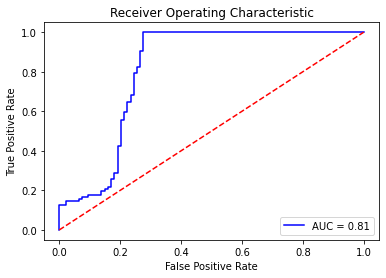

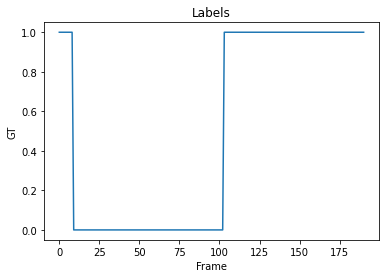

AUC:  0.7443944102139834
EER:  0.2774170407707018


In [12]:
from os import listdir
from os.path import isfile, join, isdir


clips = []
# loop over the training folders (Train000,Train001,..)
for f in sorted(listdir(Config.TEST_PATH)):
    if isdir(join(Config.TEST_PATH, f)):
      if not 'gt' in f:
        clips.append(join(Config.TEST_PATH, f))


scores = []

for i in range(len(clips)):
  if(i == 16): #skip clip 17
    continue

  Config.SINGLE_TEST_PATH = clips[i]
  Config.SINGLE_TEST_VIDEO_FILE = i+1

  print("PATH: ", Config.SINGLE_TEST_PATH)
  print("GT: ", Config.SINGLE_TEST_VIDEO_FILE)

  pr, before_reconstuction = evaluate()
  scores.append(plotROC(pr))


mean = np.mean(scores, axis=0)
#print(scores)
print("AUC: ", mean[0])
print("EER: ", mean[1])